In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import __version__ as mplVersion
mplVersion

'3.0.3'

In [2]:
# round to nearest increment
def ceil_i(val, increment):
    return np.ceil(val/increment)*increment

def round_i(val, increment):
    return np.round(val/increment)*increment


def monthly_mortgage_payment(loanAmt, apr, yrs):
    r = 1.031**(1/12)-1
    n = yrs*12
    return loanAmt*r*(1+r)**n/((1+r)**n-1)

def insurance_monthly(houseVal):
    return 0.000175*houseVal

def maintenance_yearly(houseVal):
    return .01*houseVal

def rent_monthly(houseVal):
    return round_i(houseVal*.009, 25)
    
def tax_yearly(houseVal):
    return houseVal*0.026

def hoa_monthly(houseVal):
    return round_i(0.000925*houseVal, 5)

def interest_monthly(loanAmt, apr):
    return loanAmt*apr/12

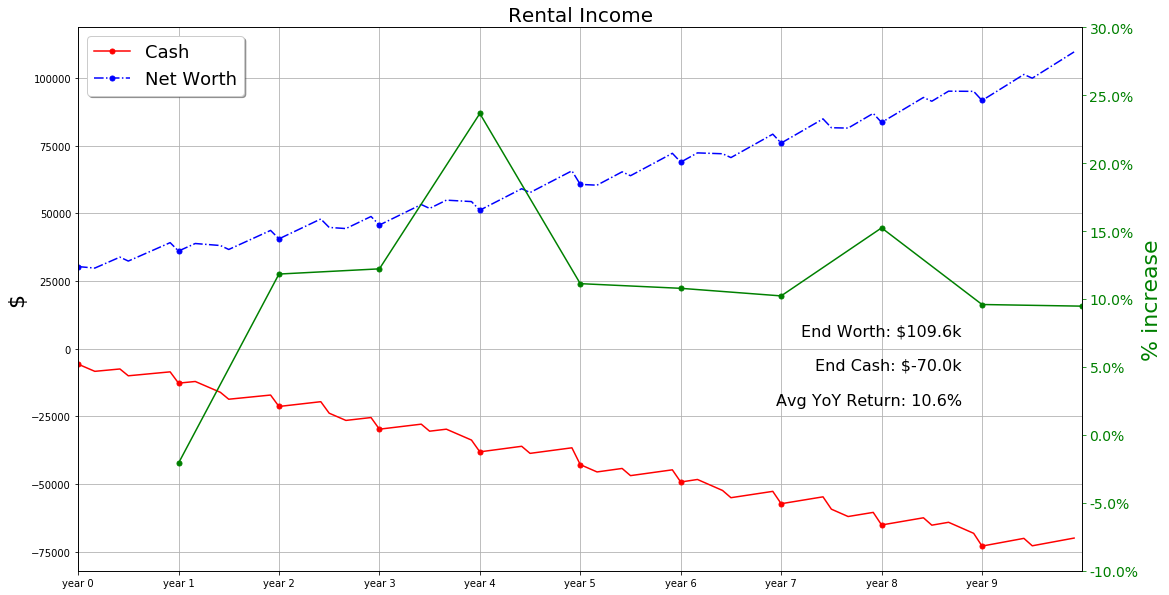

In [21]:
taxYearly0 = 5000
houseVal0 = 200000
insMonthly0 = 35
rentMonthly0 = 1800
rentServicePct = .1
closingCost = 3000

mortgageDurationYears = 15
mortgageApr = .031
downPay = .2
origination = 2000
# orig and closing get lumped in?
loanAmt = (1-downPay)*houseVal0 + origination + closingCost
monthlyMortgagePayment = monthly_mortgage_payment(loanAmt, mortgageApr, mortgageDurationYears)


houseAppreciationYearly = .02
houseAppreciationMonthly = (1+houseAppreciationYearly)**(1/12)-1

netWorth0 = downPay*houseVal0
netWorth = netWorth0
houseVal = houseVal0
cash = 0

nYrs = 10
nMos = nYrs*12
occupancy = .8
occupancyOffMos = round(12*(1-occupancy)/occupancy)

cashFlows = np.zeros(nMos)
netWorths = np.zeros(nMos)
netIncomes = np.zeros(nMos)
cashs = np.zeros(nMos)
occupyCounter = 0
occupied = False # start looking for tenant
for mo in range(nMos):
    monthCashFlow = 0
    
    # assume 12-month lease and then some empty time after to average to occupancy
    # TODO: round better, if offMos = 2.75, then off like: 3, 3, 3, 2, 3...
    # like occThresh = mo*(1-ocupancy) ... if counter==12, occThresh -=12 if true occThresh -= nOffMos
    if occupied:
        if occupyCounter == 12:
            occupied = False
            occupyCounter = 0
    else:
        if occupyCounter >= occupancyOffMos:
            occupied = True
            occupyCounter = 0

    occupyCounter += 1
    
    if mo%12 == 0:
        taxYearly = tax_yearly(houseVal)
        rentMonthly = rent_monthly(houseVal)*(1-rentServicePct)
        hoaMonthly = hoa_monthly(houseVal)
        maintenanceYearly = maintenance_yearly(houseVal)
        monthCashFlow -= maintenanceYearly + taxYearly/2 - 6*insMonthly0 # insurance 2x/year?
    
    if mo%12 == 6:
        monthCashFlow -= taxYearly/2 + 6*insMonthly0 # insurance 2x/year?
    
    monthInterest = (mortgageApr/12)*loanAmt
    monthEquity = monthlyMortgagePayment - monthInterest
    loanAmt -= monthEquity
    
    if occupied:
        monthCashFlow += rentMonthly
    
    monthCashFlow -= hoaMonthly + monthlyMortgagePayment
    cash += monthCashFlow

    houseVal *= (1 + houseAppreciationMonthly)
    
    cashFlows[mo] = monthCashFlow
    netWorths[mo] = houseVal - loanAmt + cash
    cashs[mo] = cash

netWorthEnd = netWorths[-1]
cashEnd = cashs[-1]

fig = plt.figure(figsize=(18,10))
axLeft = fig.add_subplot(111)
plt.grid(True)

# plot the damage taken vs armor data
lineCash, = axLeft.plot(cashs, color='red', linestyle='-', marker='.', markersize=10, markerfacecolor='red', markevery=12)
lineNetWorth, = axLeft.plot(netWorths, color='blue', linestyle='-.', marker='.', markersize=10, markerfacecolor='blue', markevery=12)


# format ticks, labels, axes
# axLeft.set_ylim([-1000,300000])
axLeft.set_xlim([0,nMos])
axLeft.set_ylabel('$', color='black', fontsize=22)
# axLeft.set_xlabel('time', color='black', fontsize=22)
# axLeft.tick_params('both', colors='black', labelsize=14, grid_color='black', grid_linestyle='--', grid_linewidth=.667, grid_alpha=.8)
# axLeft.set_yticks(np.linspace(yMinRight, yMaxRight, 9))
axLeft.set_xticks([yr*12 for yr in range(nYrs)])
axLeft.set_xticklabels(['year {}'.format(yr) for yr in range(nYrs)])

# create
lineCash.set_label('Cash')
lineNetWorth.set_label('Net Worth')
axLeft.legend(loc='upper left', fontsize=18, fancybox=True, shadow=True)

# the twinx makes this a 2-axis plot, different scale on right
axRight = axLeft.twinx()
axRight.set_ylabel('% increase', color='green', fontsize=22)
axRight.tick_params('y', colors='green', labelsize=14)

# yMinRight = 100*min(np.min(netWorths), np.min(cashs))/netWorth0
# yMaxRight = 100*max(np.max(netWorths), np.max(cashs))/netWorth0

yMinRight = -10
yMaxRight = 30
axRight.set_ylim([yMinRight, yMaxRight])
axRight.set_yticks(np.linspace(yMinRight, yMaxRight, 9))
axRight.set_yticklabels(['{:.1f}%'.format(v) for v in axRight.get_yticks()])

axRight.annotate('End Worth: ${:.1f}k\
\n\nEnd Cash: ${:.1f}k\
\n\nAvg YoY Return: {:.1f}%'.format(netWorthEnd/1000, cashEnd/1000, 100*((netWorthEnd/netWorth0)**(1/nYrs)-1)) , size=16, xy=(0,0), xycoords='data', xytext=(nMos*.88,2), ha='right', va='bottom')

netWorth2 = np.append(netWorth0,netWorths)
yearlyReturns = (netWorth2[12::11] / netWorth2[0:-12:11])-1
lineYearlyReturns, = axRight.plot(12*(np.arange(nYrs)+1), 100*yearlyReturns, color='green', linestyle='-', marker='.', markersize=10, markerfacecolor='green')

axLeft.set_title('Rental Income', fontsize=20)
#fig.suptitle("super title?", fontsize=20)  #displays higher/padded above plot, at least by default

plt.show()

# this syntax changed in later version of mpl?
fig.savefig('../output/rent_income.svg')